In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 2 AN2DL condivisa/W-Net

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Homework 2 AN2DL condivisa/W-Net


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [3]:
NUM_CLASSES = 5
LEARNING_RATE = 1e-4
PATIENCE = 10
EPOCHS = 1000
BATCH_SIZE = 16

In [4]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.GroupNormalization(name=name + 'gn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [5]:
from tensorflow.keras import layers
def atrous_spatial_pyramid_pooling(inputs, filters=256):
    """
    Atrous Spatial Pyramid Pooling (ASPP) module.
    """
    # Atrous Convolutions with different dilation rates
    conv1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(inputs)
    conv3_6 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=3, activation='relu')(inputs)
    conv3_12 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=6, activation='relu')(inputs)
    conv3_18 = layers.Conv2D(filters, (3, 3), padding='same', dilation_rate=9, activation='relu')(inputs)

    # Global Average Pooling
    global_avg_pool = layers.GlobalAveragePooling2D()(inputs)
    global_avg_pool = layers.Reshape((1, 1, inputs.shape[-1]))(global_avg_pool)
    global_avg_pool = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(global_avg_pool)
    global_avg_pool = layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation='bilinear')(global_avg_pool)

    # Concatenate all features
    x = layers.Concatenate()([conv1, conv3_6, conv3_12, conv3_18, global_avg_pool])
    x = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    return x

In [6]:
def channel_psa(input_tensor):
  conv1 = tfkl.Conv2D(input_tensor.shape[-1]//2, kernel_size=1, padding='same')(input_tensor)
  conv1 = tfkl.Reshape((input_tensor.shape[-1]//2, input_tensor.shape[1]*input_tensor.shape[2]))(conv1)

  conv2 = tfkl.Conv2D(1, kernel_size=1, padding='same')(input_tensor)
  conv2 = tfkl.Reshape((1,input_tensor.shape[1]*input_tensor.shape[2]))(conv2)

  conv2 = tfkl.Activation('softmax')(conv2)

  prod = tfk.ops.matmul(conv1, tfk.ops.transpose(conv2, axes = [0,2,1]))

  prod = tfkl.Reshape((1,1,prod.shape[1]))(prod)

  prod = tfkl.Conv2D(input_tensor.shape[-1], kernel_size=1, padding='same')(prod)
  prod = tfkl.LayerNormalization()(prod)
  prod = tfkl.Activation('sigmoid')(prod)

  prod2 = tfkl.Multiply()([input_tensor, prod])

  return prod2

In [7]:
def get_WNet(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path

    down_block_1 = unet_block(input_layer, 128, stack=1, name='down_block_1', kernel_size=1)
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 256, stack=2, name='down_block_2',kernel_size=3)
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    # Atrous Spatial Pyramid Pooling
    aspp = atrous_spatial_pyramid_pooling(d2)
    #aspp = channel_psa(aspp)

    # UPSAMPLING
    up_block_1 = unet_block(aspp, 256, stack=2, name='up_block_1', kernel_size=3)
    u1 = tfkl.UpSampling2D()(up_block_1)

    #u2 = tfkl.Concatenate()([u1, down_block_2])

    up_block_2 = unet_block(u1, 128, stack=1, name='up_block_2', kernel_size=5)
    u3 = tfkl.UpSampling2D()(up_block_2)

    #u4 = tfkl.Concatenate()([u3, down_block_1])

    output1 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_1')(u3)

    #Downsampling 2
    down_block_3 = unet_block(output1, 128, stack=1, name='down_block_3', kernel_size=1)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, stack=2, name='down_block_4',kernel_size=3)
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    # Atrous Spatial Pyramid Pooling
    aspp = atrous_spatial_pyramid_pooling(d4)
    #aspp = channel_psa(aspp)

    #UPSAMPLING UNet 2
    up_block_3 = unet_block(aspp, 256, stack=2, name='up_block_3', kernel_size=3)
    u5 = tfkl.UpSampling2D()(up_block_3)

    up_block_4 = unet_block(u5, 128, stack=1, name='up_block_4', kernel_size=1)
    u7 = tfkl.UpSampling2D()(up_block_4)

    output2 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_2')(u7)

    #model = tf.keras.Model(inputs=input_layer, outputs=[output1,output2], name='WNet')
    model = tf.keras.Model(inputs=input_layer, outputs=output2, name='WNet')

    return model

Model: "WNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1conv1      │ (None, 64, 128, 128) │          256 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1gn1        │ (None, 64, 128, 128) │          256 │ down_block_1conv1[… │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1activatio… │ (None, 64, 128, 128) │            0 │ down_block_1gn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 128)  │            0 │ down_block_1activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2conv1      │ (None, 32, 64, 256)  │      295,168 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2gn1        │ (None, 32, 64, 256)  │          512 │ down_block_2conv1[… │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2activatio… │ (None, 32, 64, 256)  │            0 │ down_block_2gn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2conv2      │ (None, 32, 64, 256)  │      590,080 │ down_block_2activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2gn2        │ (None, 32, 64, 256)  │          512 │ down_block_2conv2[… │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2activatio… │ (None, 32, 64, 256)  │            0 │ down_block_2gn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1        │ (None, 16, 32, 256)  │            0 │ down_block_2activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 256)          │            0 │ max_pooling2d_1[0]… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├──────────────────────

 Total params: 9,449,994 (36.05 MB)

 Trainable params: 9,449,994 (36.05 MB)

 Non-trainable params: 0 (0.00 B)

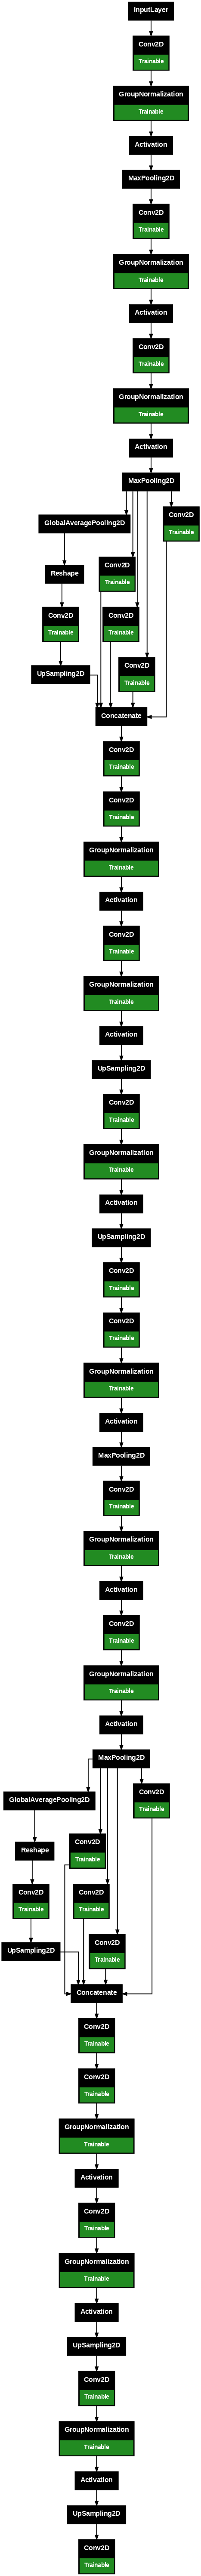

In [8]:
model = get_WNet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [9]:
def SparseCategoricalCrossentropyWithWeights(weights):
    """
    Custom Sparse Categorical Crossentropy with class weights.
    Args:
        weights: List or array of class weights, length = numClasses.
    """
    def loss_fn(y_true, y_pred):
        # Convert y_true to int32 for compatibility
        y_true = tf.cast(y_true, tf.int32)

        # Calculate the standard sparse categorical crossentropy loss
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Apply class weights
        class_weights = tf.gather(weights, y_true)  # Select weights based on y_true values
        weighted_loss = scce * class_weights

        # Return mean loss
        return tf.reduce_mean(weighted_loss)

    return loss_fn

def DiceLoss(y_true, y_pred, epsilon = 1e-6, numClasses=5):
  """
  Args:
    y_true: Ground truth, shape = (batch_size, height, width)
    y_pred: Predicted mask, shape = (batch_size, height, width, numClasses)
  """

  y_true = tf.cast(y_true, tf.int8)
  y_true_hot_enc = tf.one_hot(y_true, numClasses)

  intersection = tf.reduce_sum(y_true_hot_enc*y_pred, axis = [0,1,2])
  union = tf.reduce_sum(y_true_hot_enc + y_pred, axis= [0,1,2])

  diceXclass = (2 * intersection + epsilon) / (union + epsilon)

  lossXclass = 1 - diceXclass

  #weight = [0.3, 0.175, 0.175, 0.175, 0.175]

  return tf.reduce_mean(lossXclass)

In [10]:
weights = [0, 0.25, 0.25, 0.25, 0.25]

In [11]:
# Mean IntersectionOverUnion as metric
mean_iou = tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False)

# Compile the model
print("Compiling model...")
#model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=DiceLoss, metrics=["accuracy", mean_iou])
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=SparseCategoricalCrossentropyWithWeights(weights), metrics=['accuracy', mean_iou])
print("Model compiled!")

Compiling model...
Model compiled!


In [12]:
data = np.load("../Datasets/Dataset_cleaned.npz")
training_set = data["training_set"]

X_train = training_set[0, :]
y_train = training_set[1, :]

X_test = data["test_set"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

del data, training_set

(2505, 64, 128)
(2505, 64, 128)
(10022, 64, 128)


In [13]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)



In [14]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=0.1, random_state=seed
)

print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

del train_val_img, train_val_lbl

Splitting data...
Data splitted!

Number of images:
Train: 2028
Validation: 226
Test: 251


In [15]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [16]:
from re import X
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

del train_img, train_lbl, val_img, val_lbl, test_img, test_lbl
#del test_dataset,X_test

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (16, 64, 128)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'float64'>


In [17]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'WNet_'+str(final_val_meanIoU)+'_DiceLoss.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 99s 466ms/step - accuracy: 0.2896 - loss: 0.2231 - mean_io_u: 0.1110 - val_accuracy: 0.4524 - val_loss: 0.2016 - val_mean_io_u: 0.2518 - learning_rate: 1.0000e-04
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 79s 191ms/step - accuracy: 0.3903 - loss: 0.1899 - mean_io_u: 0.2361 - val_accuracy: 0.5037 - val_loss: 0.1717 - val_mean_io_u: 0.3109 - learning_rate: 1.0000e-04
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.4388 - loss: 0.1758 - mean_io_u: 0.2837 - val_accuracy: 0.4981 - val_loss: 0.1768 - val_mean_io_u: 0.3047 - learning_rate: 1.0000e-04
Epoch 4/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.4696 - loss: 0.1648 - mean_io_u: 0.3163 - val_accuracy: 0.5396 - val_loss: 0.1558 - val_mean_io_u: 0.3641 - learning_rate: 1.0000e-04
Epoch 5/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - accuracy: 0.4865 - loss: 0.1595 - mean_io_u: 0.3329 - val_accuracy: 0.5253 - val_loss: 0.1556 - val_mean_io_u: 0.3373 - l

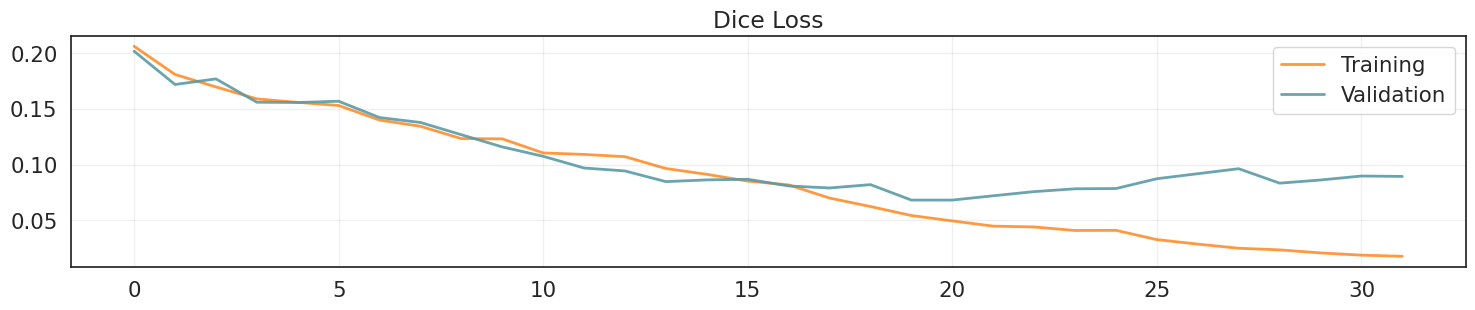

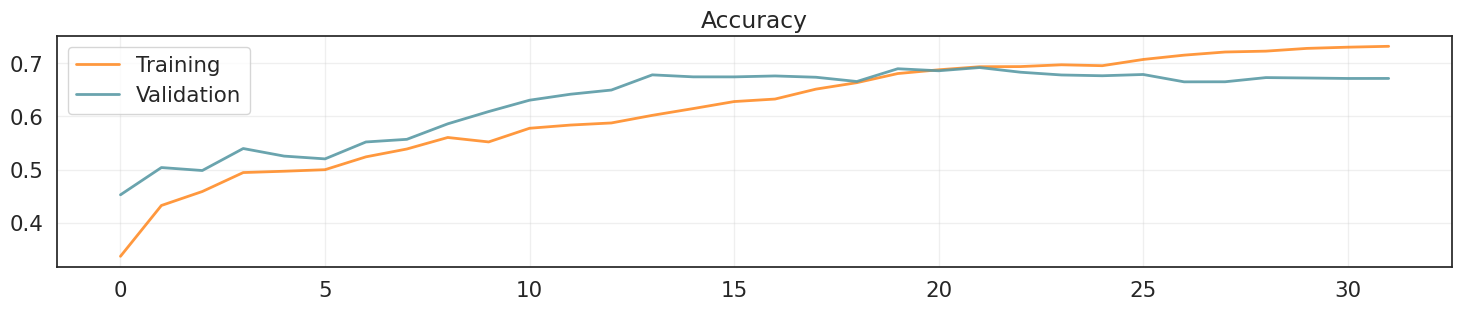

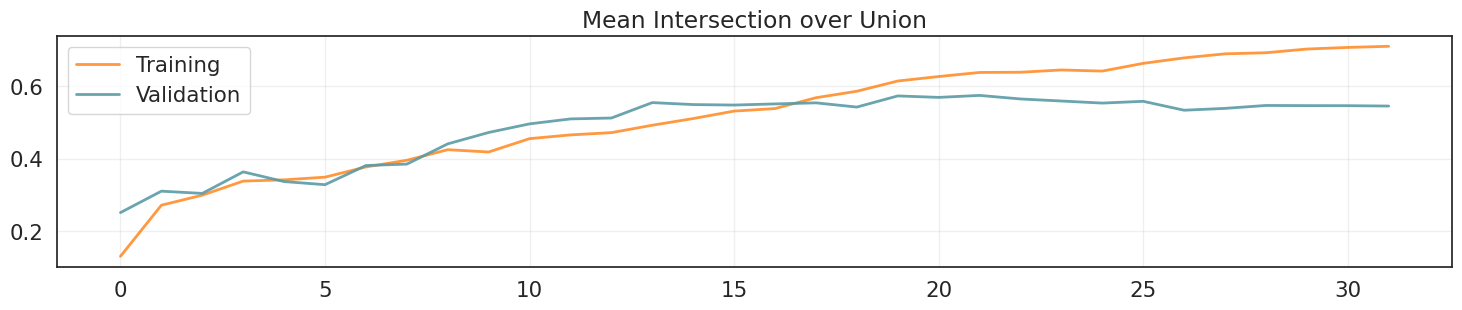

In [18]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Dice Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Model: "WNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1conv1      │ (None, 64, 128, 128) │          256 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1gn1        │ (None, 64, 128, 128) │          256 │ down_block_1conv1[… │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_1activatio… │ (None, 64, 128, 128) │            0 │ down_block_1gn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 128)  │            0 │ down_block_1activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2conv1      │ (None, 32, 64, 256)  │      295,168 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2gn1        │ (None, 32, 64, 256)  │          512 │ down_block_2conv1[… │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2activatio… │ (None, 32, 64, 256)  │            0 │ down_block_2gn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2conv2      │ (None, 32, 64, 256)  │      590,080 │ down_block_2activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2gn2        │ (None, 32, 64, 256)  │          512 │ down_block_2conv2[… │    Y    │
│ (GroupNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block_2activatio… │ (None, 32, 64, 256)  │            0 │ down_block_2gn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1        │ (None, 16, 32, 256)  │            0 │ down_block_2activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 256)          │            0 │ max_pooling2d_1[0]… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├──────────────────────

 Total params: 9,449,994 (36.05 MB)

 Trainable params: 9,449,994 (36.05 MB)

 Non-trainable params: 0 (0.00 B)

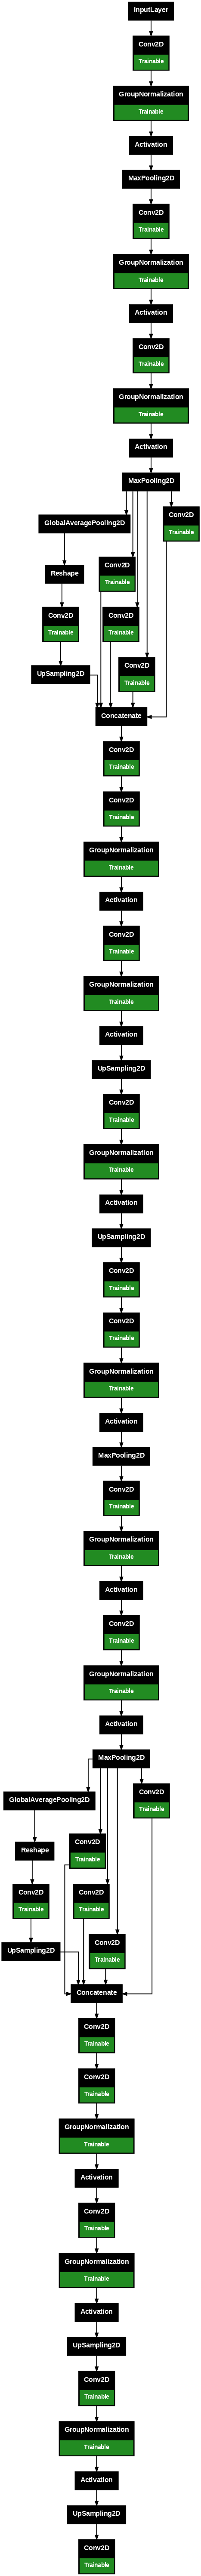

In [19]:
# Load UNet model without compiling
#model_filename = 'SegNet_48.55.keras'
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
# model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=SparseCategoricalCrossentropyWithWeights(weights), metrics=["accuracy", mean_iou])
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=SparseCategoricalCrossentropyWithWeights(weights), metrics=["accuracy", mean_iou])

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [20]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step - accuracy: 0.6435 - loss: 0.0902 - mean_io_u: 0.5420
Test Accuracy: 0.6324
Test Mean Intersection over Union: 0.5332


In [21]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [22]:
print(model_filename)

WNet_57.49_DiceLoss.keras


In [24]:
# Prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 56s 142ms/step
Predictions shape: (10022, 64, 128)


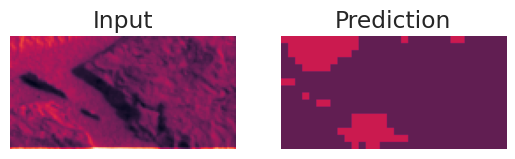

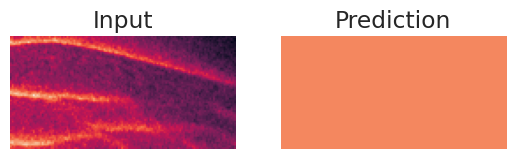

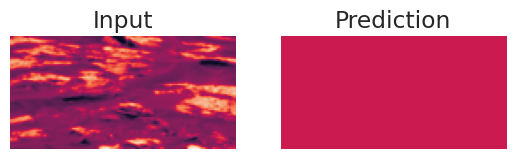

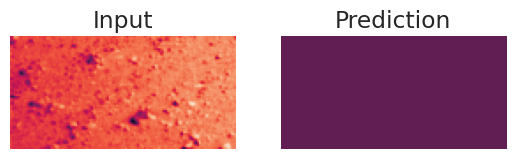

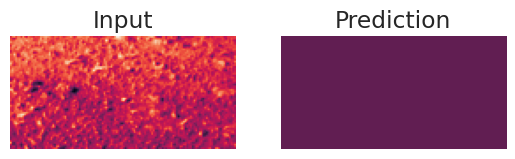

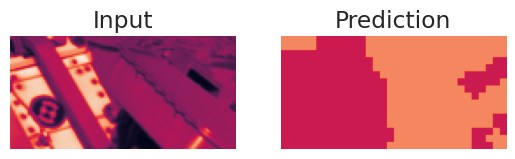

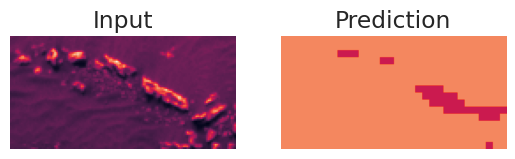

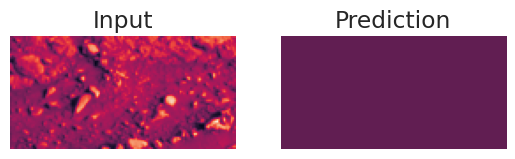

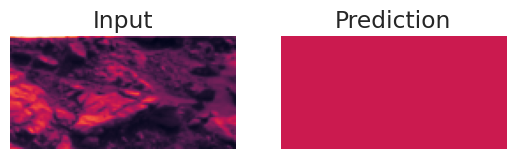

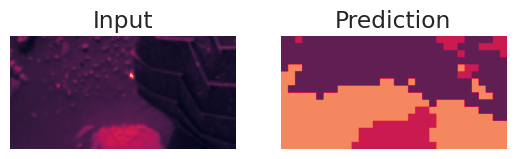

In [25]:
for i in range(10):
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.axis('off')
  plt.title("Input")
  plt.subplot(1,2,2)
  plt.imshow(preds[i], vmin = 0, vmax = 4)
  plt.axis('off')
  plt.title("Prediction")
  plt.show()

In [26]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [27]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-
